# Evaluation of the model output

In [1]:
# Import libraries
import os,sys,pathlib
from datetime import datetime
from config.config import get_cfg_defaults, combine_cfgs
import matplotlib.pyplot as plt

from transformers import DetrImageProcessor
from tools import DETR_Wrapp, update_log_screen
from modeling.ModelTools import get_model
from data.DataTools import get_data

# from detr.datasets import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import torch
from pprint import pprint

from Visualise import format_data, draw_boxes

c:\Users\jayan\anaconda3\envs\DTx\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialise config and dataloader
config_path = 'config/Exps/DTx_MS_CL.yaml'
config = combine_cfgs(config_path)
val_dataset, val_dataloader =  get_data(config, data_tag='val', shuffle=True)

c:\Users\jayan\anaconda3\envs\DTx\lib\site-packages\transformers\models\detr\image_processing_detr.py:776: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


loading annotations into memory...
Done (t=1.64s)
creating index...
index created!
Number of samples for val from C:\Users\jayan\Documents\MECHATRONICS YR4\MECH5845M - Professional Project\DSAD4DeTr\val\annotations\val_annotations.json: 1978
Batch size for val: 4


In [3]:
# Set up the model
detector = get_model(config)
model = DETR_Wrapp(detector, config)
model_path = "final_00.pt"
model.model.load_state_dict(torch.load(model_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([12]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([12, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Changing backbone config.
Adding Res2Net multiscale blocks
Using Res2Net res2net50_26w_4s
Adding connections for dense inference.
Used feature maps are [2, 3]


FileNotFoundError: [Errno 2] No such file or directory: 'final_00.pt'

In [ ]:
# Initialise feature extractor
feat_extractor = DetrImageProcessor(do_normalize=config.DATA.normalize,
        size=config.DATA.resize_shortedge, max_size=config.DATA.resize_longedge,
        image_mean=config.DATA.image_mean, image_std=config.DATA.image_std)
# Initialise image location
image_location = pathlib.Path.cwd() / "image_results"
if not image_location.exists():
    os.makedirs(image_location)

In [ ]:
def evaluation(current_loader,model,device,feat_extractor,
               images_out=False,image_location=None,config=None):
    model.to(device)
    base_dataset = current_loader.dataset.coco
    iou_types = ['bbox']
    coco_evaluator = CocoEvaluator(base_dataset, iou_types) # initialize evaluator with ground truths

    # Define class dictionary for image labelling
    classes = {
        1: "abdominal_wall",
        2: "colon",
        3: "inferior_mesenteric_artery",
        4: "intestinal_veins",
        5: "liver",
        6: "pancreas",
        7: "small_intestine",
        8: "spleen",
        9: "stomach",
        10: "ureter",
        11: "vesicular_glands"
    }

    batches_to_show = 1
    batches_shown = 0

    with torch.no_grad():
        for idx, batch in enumerate(current_loader):
            if batches_shown >= batches_to_show:
                break
            # get the inputs
            pixel_values = batch["pixel_values"].to(device)
            pixel_mask = batch["pixel_mask"].to(device)
            labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

            pprint(len(labels))
            # forward pass
            outputs = model.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
            #pprint(outputs)
            for key, value in outputs.items():
                if isinstance(value, torch.Tensor):
                    print(f"Key: {key}, Shape: {value.size()}")
                else:
                    print(f"Key: {key}, Value type: {type(value)}")

            orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
            results = feat_extractor.post_process_object_detection(outputs,
                                        target_sizes=orig_target_sizes,threshold=0.5) # convert outputs of model to COCO api
            pprint(f"Results: {results}")
            res = {target['image_id'].item(): output for target, output in zip(labels, results)}
            pprint(f"Res: {res}")
            coco_evaluator.update(res)
            pprint(f"Coco: {coco_evaluator}")

            # Print image
            # if images_out:
            #     if batches_shown < batches_to_show:
            #         image_path = image_location
            #         see_output(outputs, batch, classes, config, image_path)
            #     else:
            #         break
            batches_shown += 1

            del outputs

    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

In [ ]:
# Define see_output
def see_output(output, batch, id2label, config, save_path):
    """ Visualise the output of the model
    Args:
        output (dict): Output of the model
        batch (dict): Batch of samples to visualise
        id2label (dict): Dictionary mapping class indices to class names
        config (dict): Config dictionary
    """
    GT_COLOR = (10,70,0)
    P_COLOR = (20,0,255)
    pixel_values = batch["pixel_values"]
    labels = batch["labels"]
    batch_size = len(labels)

    if int(batch_size/4)<1:
        rows,cols = 1,batch_size
    else:
        rows,cols = int((3+batch_size)/4) , 4
    
    fig, axes = plt.subplots(rows,cols,figsize=(25,13))
    for item,ax in enumerate(fig.axes):
        # Debugging prints
        # print(f"Type of output: {type(output)}")
        # print(output.keys())
        print(f"Pred boxes: {output['pred_boxes'][item].size()}")
        # print(f"Type of output[item]: {type(output[item])}")
        print(f"Output[item]: {output[item]}")
        print(f"labels: {labels}")
        print(f"labels[item]: {labels[item]}")
        ax.set_axis_off()
        if item<batch_size:
            img = pixel_values[item,:,:,:]
            p_boxes = output['pred_boxes'][item]
            labels[item].update(output[item])
            img, boxes = format_data(img,labels[item],config)
            print(boxes)

            if 'image_id' in labels[item].keys():
                img_id = labels[item]['image_id'].numpy()[0]
                ax.set_title(f"Image ID: {img_id}")
            
            if 'boxes' in boxes.keys():
                gt_boxes = boxes['boxes']
                tags = [f"{id2label[idx]}"  for idx in labels[item]['class_labels'].numpy()]
                draw_boxes(img, gt_boxes, tags, True, GT_COLOR)

            if 'p_boxes' in boxes.keys():
                pred_boxes = boxes['p_boxes']
                tags = [f"{id2label[idx]} {100*score:3.2f}%"  for idx,score 
                        in zip(labels[item]['p_class'].numpy(),labels[item]['p_score'].numpy())]
                draw_boxes(img, pred_boxes, tags, False, P_COLOR)

            print(f"Image id: {img_id}\nGT Boxes: {gt_boxes}\nP Boxes: {pred_boxes}\n")

            ax.imshow(img)

            image_path = os.path.join(save_path, f"output_{img_id}.png")
            img.save(image_path)

In [ ]:
# Run evaluation script
evaluation(val_dataloader,model,device,feat_extractor,
            images_out=True,image_location=image_location,config=config)

c:\Users\jayan\anaconda3\envs\DTx\lib\site-packages\transformers\models\detr\image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


4
Key: logits, Shape: torch.Size([4, 100, 12])
Key: pred_boxes, Shape: torch.Size([4, 100, 4])
Key: last_hidden_state, Shape: torch.Size([4, 100, 256])
Key: encoder_last_hidden_state, Shape: torch.Size([4, 730, 256])
("Results: [{'scores': tensor([]), 'labels': tensor([], dtype=torch.int64), "
 "'boxes': tensor([], size=(0, 4))}, {'scores': tensor([]), 'labels': "
 "tensor([], dtype=torch.int64), 'boxes': tensor([], size=(0, 4))}, {'scores': "
 "tensor([]), 'labels': tensor([], dtype=torch.int64), 'boxes': tensor([], "
 "size=(0, 4))}, {'scores': tensor([]), 'labels': tensor([], "
 "dtype=torch.int64), 'boxes': tensor([], size=(0, 4))}]")
("Res: {1032644: {'scores': tensor([]), 'labels': tensor([], "
 "dtype=torch.int64), 'boxes': tensor([], size=(0, 4))}, 1062118: {'scores': "
 "tensor([]), 'labels': tensor([], dtype=torch.int64), 'boxes': tensor([], "
 "size=(0, 4))}, 1080313: {'scores': tensor([]), 'labels': tensor([], "
 "dtype=torch.int64), 'boxes': tensor([], size=(0, 4))}, 11021

In [ ]:
var = torch.randn(1,1)
print(float(var))

-0.8908640742301941


# Testing Section

c:\Users\jayan\anaconda3\envs\DTx\lib\site-packages\transformers\models\detr\image_processing_detr.py:882: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


5
5
11
11
11
4
2
2
2
10
10
11
11
1


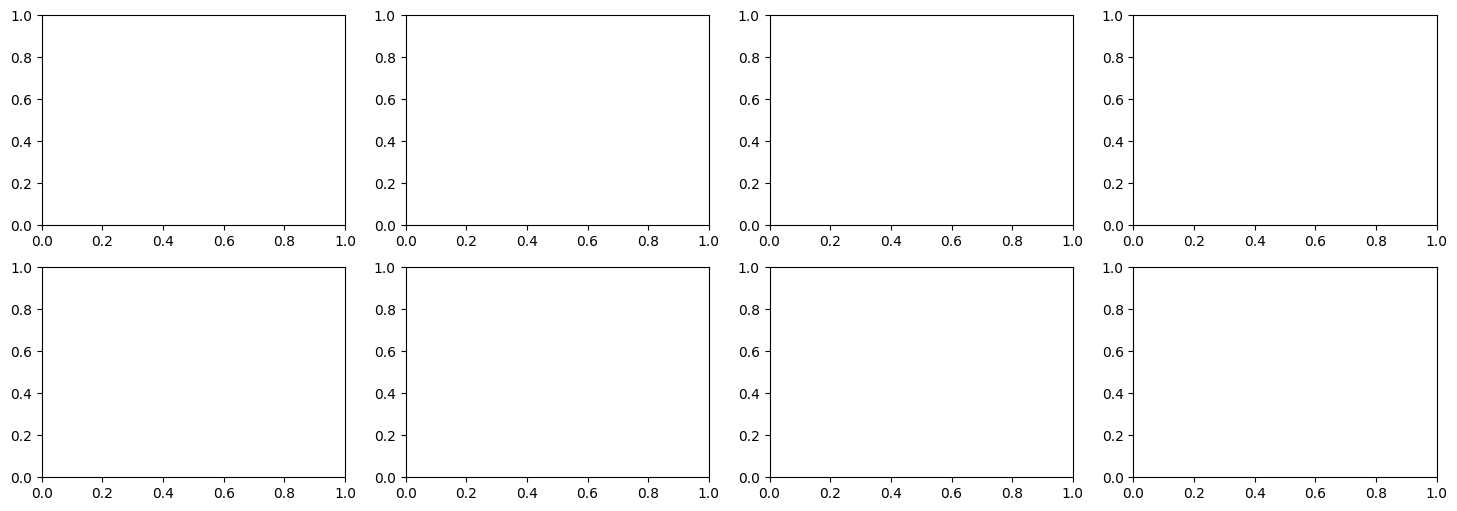

In [ ]:
# Testing for the dataloader
counter = 0
for idx, batch in enumerate(test_dataloader):
    counter += 1
    if counter > 10:
        break
    # pprint(batch['labels'])
    labels = batch['labels']
    
    if int(len(labels)/4)<1:
        rows,cols = 1,len(labels)
    else:
        rows,cols = int((3+len(labels))/4) , 4
    
    fig, axes = plt.subplots(rows,cols,figsize=(18,6))
    for item,ax in enumerate(fig.axes):
        for i in range(len(labels[item]['class_labels'])):
            class_idx = labels[item]['class_labels'].numpy()[i]
            print(class_idx)
    break